In [152]:
import pandas as pd

from significance_analysis import conduct_analysis

# Load example dataset
data = pd.read_csv("./example_dataset.csv")

In [116]:
import numpy as np
import matplotlib.pyplot as plt
def algo_simulator(budget:int,workers_power:int,quality:float,noise:float):
    runs=[]

    for i in range((2**workers_power)):
        runs.append([1])
    prev_workers=2**workers_power
    for i in range(1,budget):
        #print(runs)
        multiplier=budget/(i+1)
        current_workers=2**min(np.floor(np.log2(multiplier)),workers_power)
        runs= sorted(runs, key=lambda x: x[-1])
        if current_workers!=prev_workers:
            #print(current_workers)
            for worker in range(int(current_workers)):
                new_point=(np.exp(-quality*i)+np.random.normal(size=1,scale=noise))[0]
                runs[worker].append(min([runs[worker][-1],new_point]))
        prev_workers=current_workers
    return runs

algo_simulator(16,3,2,0.1)

[[1, -0.20052481985267384, -0.20052481985267384, -0.20052481985267384],
 [1, -0.035372070640061315, -0.035372070640061315],
 [1, 0.04890040859496762],
 [1, 0.09758018071657991],
 [1],
 [1],
 [1],
 [1]]

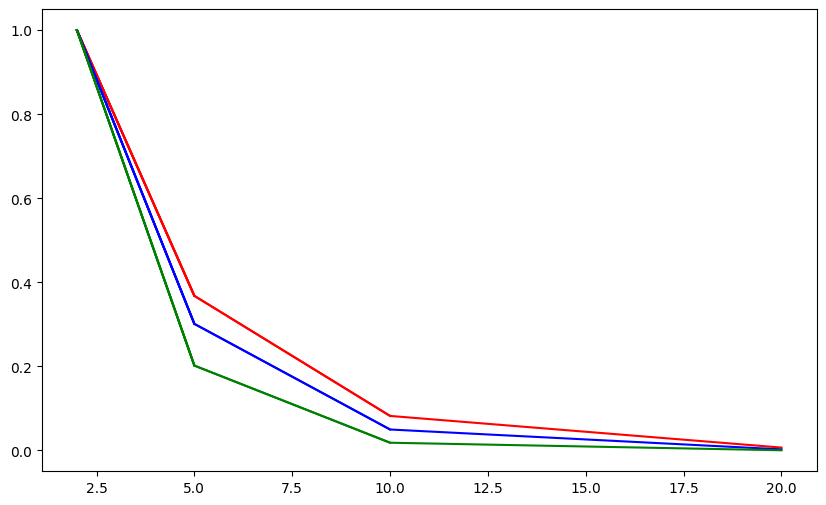

In [199]:
max_budget=20
number_of_workers_power=3
quality=[0.5,0.6,0.8]
colors=["red","blue","green"]
noise=0.

runs=[]
y_data=[]
algo_numbers=[]
for algo_number in range(len(quality)):
    run=algo_simulator(budget=max_budget,workers_power=number_of_workers_power,quality=quality[algo_number],noise=noise)
    runs+=run
    algo_numbers+=list(np.ones(shape=len(run),dtype=int)*algo_number)

for run in runs:
    y_data.append([])
    for i in range(0,len(run)):
        y_data[-1].append(int((2**i/2**number_of_workers_power)*max_budget))



_, axis = plt.subplots(figsize=(10, 6))
for number,group in enumerate(runs):
    axis.errorbar(
        y_data[number],
        group,
        fmt="-",
        color=colors[algo_numbers[number]]
    )
plt.show()

In [175]:
saved_runs=runs
saved_y_data=y_data
saved_algo_numbers=algo_numbers


In [196]:
import warnings
import random
warnings.simplefilter(action='ignore', category=FutureWarning)

"""
_, axis = plt.subplots(figsize=(10, 6))
for number,group in enumerate(saved_runs):
    axis.errorbar(
        saved_y_data[number],
        group,
        fmt="-",
        color=colors[algo_numbers[number]]
    )
plt.show()"""

df=pd.DataFrame(columns=["score","budget","algo","rng"])
for run_number,run in enumerate(saved_runs):
    for data_number,datapoint in enumerate(run):
        df.loc[len(df)] =[datapoint,saved_y_data[run_number][data_number],str(saved_algo_numbers[run_number]),str(random.randint(0,2))]


#conduct_analysis(df,"score","algo","rng")

In [200]:
from pymer4 import Lmer

metric="score"
system_id="algo"
input_id="rng"
random_effect="budget"

different_means_model = Lmer(
    formula=f"{metric}~{system_id}+{random_effect}+(1|{input_id})", data=df
)

# factors specifies names of system_identifier, i.e. Baseline, or Algorithm1
different_means_model.fit(
    factors={system_id: list(df[system_id].unique())},
    REML=False,
    summarize=False,
)

post_hoc_results = different_means_model.post_hoc(marginal_vars=[system_id])
print(post_hoc_results)

P-values adjusted by tukey method for family of 3 estimates
(  algo  Estimate  2.5_ci  97.5_ci     SE      DF
1    0     0.634   0.498    0.771  0.064  15.385
2    1     0.595   0.458    0.732  0.064  15.385
3    2     0.595   0.454    0.736  0.065  11.943,         Contrast  Estimate  2.5_ci  97.5_ci     SE      DF  T-stat  P-val Sig
1  algo0 - algo1     0.039  -0.174    0.253  0.088  41.669   0.448  0.896    
2  algo0 - algo2     0.039  -0.176    0.255  0.089  44.418   0.443  0.898    
3  algo1 - algo2    -0.000  -0.215    0.215  0.089  44.418  -0.001  1.000    )
